# 实验4：GARCH(1, 1)的数值模拟

## 背景介绍： 
自从Engle(1982)提出自回归条件异方差模型（Autoregressive Conditional Heteroskedasticity Model，ARCH）分析时间序列的异方差性以后，Bollerslev(1986)又提出了广义自回归条件异方差模型(Generalized AutoRegressive Conditional Heteroskedasticity Model，GARCH)，其对误差的方差进行了进一步的建模，主要用于波动性的分析和预测。
GARCH(p, q)的基本形式为
$$
\begin{align}
& r_t=\sigma_t\epsilon_t \tag{1}\\
& \sigma^2_t=\omega+\sum_{i=1}^{p} {\alpha_ir^2_{t-i}}+\sum_{j=1}^{q} {\beta_j\sigma^2_{t-j}}\tag{2}
\end{align}
$$
其中，$\omega>0，\alpha_i\geq0，\beta_j\geq0，\epsilon_t\sim i.i.d(0, 1)$。

我们已知的是$r_t$序列，需要估计的参数是$\omega，\alpha_i，\beta_j$，估计方法是条件极大似然估计。  
GARCH模型在刻画收益率序列波动率的优势在于  
* 能够刻画收益率的波动率聚集现象，即一个大的波动往往跟随着一个大的波动；  
* GARCH过程分布的尾部比正态分布尾部厚，可以刻画收益率序列尖峰厚尾的现象。  

因此通过分析一个时间序列的GARCH过程，可以较好的预测其未来的波动率。

## 学习资料
*  [GARCH模型讲义]
2. Hamilton(1994)第21章
3. Fan and Yao(2006)第3章
4. 《金融时间序列分析》第3章
[GARCH模型讲义]:./data.csv

## 前置要求
1. **熟悉R读、写文件的基本方法** （[实验二]) 
2. 理解极大似然估计（MLE）方法（实验三内容）
3. 对数值模拟简单了解
[实验二]:../a/a.pynb

## 实验环境要求
1. 软件环境：R或Jupyter
2. R的fGarch包
3. 准备CSV数据文件“data.csv”  _data 文档描述

## 实验要点：

步骤一：生成一个**GARCH(1, 1)模型**的参数，即ω、α和β值，GARCH的基本形式参考讲义的(34)(35)式  
步骤二：由参数和随机项模拟出收益率序列  
步骤三：估计模拟收益率序列的GARCH(1, 1)参数  
步骤四：对比估计的参数和实际的参数，分析GARCH(1, 1)模型的估计精度


## 实验目标：
1. 理解GARCH模型的形式和思想
2. 学习GARCH(1, 1)的估计方法，理解GARCH模型的估计精确度
3. 理解数值模拟的思想方法
4. 熟练掌握用R完成上述模型的实现过程
5. 学习优化R的输出结果

## 预期结果：
通过对比实际参数和估计参数，检验GARCH模型是否能够准确地对波动率建模和预测。

# 实验过程

## 项目一：得到实际参数向量$\hat{\theta}$
为了接下来生成一个满足GARCH(1, 1)过程的时间序列，我们首先要定义参数。一般的，我们可以根据经验自行定义GARCH(1, 1)的实际参数$\hat{\theta}$。  
但这里，由于我们不清楚实际参数应该在设置在哪一个区间内，例如$\hat{\omega}$能否大于1，能否为负等等。因此我们使用一个收益率时间序列估计出其GARCH(1, 1)参数，将其作为我们用来模拟时间序列的参数。

目标：使用S&P500指数的收益率序列得到用于数值模拟的实际参数向量$\hat{\theta}$ = ($\hat{\omega}$, $\hat{\alpha}$, $\hat{\beta}$)

### 1.1 设定工作目录，加载包

In [2]:
setwd("./")
library(fGarch)

Loading required package: timeDate
Loading required package: timeSeries
Loading required package: fBasics


### 1.2  读取数据，并计算S&P500指数的收益率

In [3]:
raw_data <- read.csv("./data.csv", stringsAsFactors=F)
SP500 <- raw_data[, "SP500"]

收益率计算公式如下：
$$收益率\,=\,当日收盘指数 \,/\,前一日收益指数\,-\,1$$  
根据公式，可以看到有两种方法计算收益率

第一种方法，我们可以使用循环的方式计算：

In [4]:
SP500_rtn <- rep(NA, length(SP500) - 1)  # 定义收益率序列，产生（指数长度-1）个NA值
for(i in 1: length(SP500)) {
  SP500_rtn[i] <- SP500[i + 1] / SP500[i] -1 
}

循环的方式简单易懂，与C++等语言的方法类似，但写起来繁琐，在R中有更好的方式。
另一种更为常用的方式是使用向量化运算，其公式如下：
$$
\left\lgroup\begin{matrix} r_{2} \cr r_{3} \cr \cdots \cr r_{t}\end{matrix} \right\rgroup
\,=\,
\left\lgroup\begin{matrix} P_{2} \cr P_{3} \cr \cdots \cr P_{t}\end{matrix} \right\rgroup
\,\div\,
\left\lgroup\begin{matrix} P_{1} \cr P_{2} \cr \cdots \cr P_{t-1}\end{matrix} \right\rgroup
\,-\,
\left\lgroup\begin{matrix} 1 \cr 1 \cr \cdots \cr 1\end{matrix} \right\rgroup
$$
在R中，与MATLAB等科学计算语言类似，对两个向量之间进行加减乘除默认是两个向量对应元素的加减乘除，因此可以很方便地得到收益率序列。

In [5]:
SP500_rtn <- SP500[2: length(SP500)] / SP500[1: (length(SP500) - 1)] - 1  #向量运算，得到收益率

上式中值得注意的一点是，SP500\[1: (length(SP500) - 1)\]中(length(SP500) - 1)左右的括号必须有，否则会索引\[0: (length(SP500) - 1)\]的数据，即先得到1: (length(SP500)的序列，再减去1。下面这个例子可以明显看到区别。

In [6]:
print(SP500[2: (10 - 1)])

[1] 1136.52 1137.14 1141.69 1144.98 1146.98 1136.22 1145.68 1148.46


In [7]:
print(SP500[2: 10 - 1])

[1] 1132.99 1136.52 1137.14 1141.69 1144.98 1146.98 1136.22 1145.68 1148.46


### 1.3 使用“fGarch”包的garchFit函数进行估计得到$\hat{\theta}$

In [8]:
raw_fit <- garchFit(~garch(1, 1), data=SP500_rtn, trace=F) 

garchFit()函数的参数说明：
1. 第一个参数为GARCH模型形式，我们这里使用GARCH(1, 1)进行估计。因为GARCH(1, 1)只需要估计3个参数，并且能够较好的估计波动率，因此我们这里使用GARCH(1, 1)模型，在实际中，我们也可以使用信息准则的方法去确定最优阶数。
2. 第二个参数为收益率序列
3. trace=F表示估计过程不打印在屏幕上

由于估计出来的raw_fit是一个S4对象，因此使用“@”符号来从raw_fit中取出需要的参数list，然后将参数list依次赋值给参数对象。  
在R里面，有S3和S4对象，对此这里不做介绍，有兴趣的同学可以参考中高级R教程进行学习（例如[《Advanced R》](http://adv-r.had.co.nz/)）  
一般而言S3对象使用$符号提取数据，S4对象使用@符号提取数据。这个例子里，raw_fit是一个S4对象，而raw_fit@fit得到一个list是S3对象。  

In [9]:
print(raw_fit@fit$coef)
omega_hat <- raw_fit@fit$coef["omega"]
alpha_hat <- raw_fit@fit$coef["alpha1"]
beta_hat <- raw_fit@fit$coef["beta1"]

          mu        omega       alpha1        beta1 
8.857529e-04 3.343886e-06 1.182697e-01 8.601660e-01 


## 项目二：数值模拟
我们利用从SP500指数中估计得到参数$\hat{\theta}$ = ($\hat{\omega}$, $\hat{\alpha}$, $\hat{\beta}$)，以及生成的随机项模拟出一个收益率序列，其思路如下：  
参考式（1）和式（2）
$$
\begin{align}
& r_t=\sigma_t\epsilon_t \tag{1}\\
& \sigma^2_t=\omega+\sum_{i=1}^{p} {\alpha_ir^2_{t-i}}+\sum_{j=1}^{q} {\beta_j\sigma^2_{t-j}}\tag{2}
\end{align}
$$
其中，$\omega>0，\alpha_i\geq0，\beta_j\geq0，\epsilon_t\sim i.i.d(0, 1)$。  
我们可以看到，对于GARCH(1, 1)模型，如果已知了
1. $\omega，\alpha，\beta$
2. $\sigma$在$t=1$时的初始值$\sigma_1$
3. 服从标准正态分布的$\epsilon_t$序列

然后就可以通过迭代的方法得到GARCH(1, 1)模型的$r_t$序列：
$$
\begin{align}
& r_1=\sigma_1\epsilon_1\\
& r_2=\sigma_2\epsilon_2, \,\sigma^2_2=\omega+\alpha r^2_{1}+\beta\sigma^2_{1}\\
& r_3=\sigma_3\epsilon_3, \,\sigma^2_3=\omega+\alpha r^2_{2}+\beta\sigma^2_{2}\\
& \cdots\\
& r_t=\sigma_t\epsilon_t, \,\sigma^2_t=\omega+\alpha r^2_{t-1}+\beta\sigma^2_{t-1}
\end{align}
$$

接下来我们沿着这个思路来做。因为我们已经计算出了$\omega，\alpha，\beta$，之后需要得到第2点和第3点。

### 2.1 定义参数和对象
首先要定义一些必要的参数。
* 设定需要模拟的收益率的个数
* 通过提前设定好随机数种子，使用同一个随机数的生成过程，能够保证每次运行的结果是一样的。

然后预定义一些对象。

In [10]:
# 参数设定
total_num <- 5000  # 收益率的个数
set.seed(666)  # 设定随机数种子

simu_rtn <- rep(NA, total_num)  # 定义模拟的收益率序列
sigma <- rep(NA, total_num)  # 定义sigma序列

### 2.2 生成随机数序列
使用rnorm(n, mu, sigma)函数生成有n个随机观测值的时间序列，其服从均值为mu，标准差为sigma的正态分布。这样我们就得到$\epsilon_t$的序列。

In [11]:
epsilon <- rnorm(total_num, 0 ,1)  # epsilon~N(0, 1)，生成服从标准正态分布的随机残差项

### 2.3 计算初始值
然后我们计算$\sigma$在$t=1$时的初始值$\sigma_1$。  
参考讲义（47）式，可以知道GARCH(1, 1)模型中$\sigma^2$的长期均值$$\sigma^2=\frac{\omega}{1-\alpha_1+\beta_1}$$  
由于$\sigma_1$未知，并且需要我们提前设定，使用长期均值作为$\sigma_1$的值是一个较好的方法

In [12]:
# t=1时的初始值
sigma[1] <- sqrt(omega_hat / (1 - alpha_hat - beta_hat))   # 使用sigma的长期均值作为其t=1时的值
simu_rtn[1] <- sigma[1] * epsilon[1]  # t=1时的收益率值

### 2.4 迭代得到模拟收益率序列
根据前面对GARCH(1, 1)模型迭代方法的介绍，使用参数值$\hat{\theta}$、$\sigma_1$和随机项$\epsilon_t$循环得到模拟收益率。  
这里不能使用向量计算的方法，因为每一次迭代都会需要前一次的值。

In [13]:
for (i in 2: total_num) {
  sigma[i] <- sqrt(omega_hat + alpha_hat * (simu_rtn[i - 1]) ^ 2 + beta_hat * (sigma[i - 1]) ^ 2)
  simu_rtn[i] <- sigma[i] * epsilon[i]
}

## 项目三：计算模拟收益率下的参数
使用项目二得到的收益率序列，进行GARCH(1, 1)估计，得到估计值$\theta$ = ($\omega$, $\alpha$, $\beta$)。  
我们会分别使用250, 500, 750, 1000个收益率进行估计，便于分析用于估计参数的收益率个数和参数精确度之间的关系。

### 3.1 定义参数和对象

In [14]:
# 提前定义参数
cal_num <- c(250, 500, 750, 1000)

预定义好输出结果矩阵，将之后估计的参数放入其中

In [15]:
result <- matrix(NA, length(cal_num) + 1, 4)
result[1, ] <- raw_fit@fit$coef  # 原始参数作为对比放入第一行

### 3.2 估计GARCH(1, 1)参数
这里我们用循环的方式估计不同个数收益率序列的GARCH(1, 1)参数，估计方法第一部分估计$\hat{\theta}$的方式一致。  
由于经过了非常多次加入随机项的迭代，收益率序列基本上不能体现原有的实际参数$\hat{\theta}$，因此使用最近的250, 500, 750, 1000个收益率序列进行估计，可以有效地评估GARCH(1, 1)模型的效果。

In [16]:
for (i in 1: length(cal_num)) {
  cal_num_i <- cal_num[i]
  # 这里的估计方式和第一部分一致，使用最近的250, 500, 750, 1000个收益率序列
  result[i + 1, ] <- garchFit(~garch(1, 1), data=simu_rtn[(5000 - cal_num_i + 1): 5000], trace=F)@fit$coef
}
print(result)

              [,1]         [,2]      [,3]      [,4]
[1,]  0.0008857529 3.343886e-06 0.1182697 0.8601660
[2,] -0.0007118179 2.359254e-05 0.1937847 0.6605254
[3,] -0.0004727766 9.651982e-06 0.1230494 0.8109529
[4,] -0.0001840464 4.559540e-06 0.1214436 0.8616245
[5,] -0.0001699982 4.227803e-06 0.1341504 0.8585705


至此，我们得到了估计结果，接下来对输出形式进行优化。

## 项目四：优化输出结果形式
因为我们关注估计值$\theta=(\omega，\alpha，\beta)$和实际参数$\hat{\theta}$ = ($\hat{\omega}$, $\hat{\alpha}$, $\hat{\beta}$)的估计差别，因此将差值计算并展示出来能够有利于分析，同时，注明列名也能够清晰展示结果。

### 4.1 定义参数和对象
首先定义输出矩阵。  
使用paste0()函数可以将字符串连接在一起，若其中既有标量又有向量，则标量会复制向量长度次使得二者能够一一连接。

In [17]:
result <- result[, -1]  # 我们不关心均值，将其删除
rownames(result) <- paste0("theta_", c("hat", as.character(cal_num)))
colnames(result) <- c("omega", "alpha1", "beta1")

下面两种方式相等

In [18]:
print(paste0("theta_", c("hat", as.character(cal_num))))

[1] "theta_hat"  "theta_250"  "theta_500"  "theta_750"  "theta_1000"


In [19]:
print(paste0(rep("theta_", length(c("hat", as.character(cal_num)))), c("hat", as.character(cal_num))))

[1] "theta_hat"  "theta_250"  "theta_500"  "theta_750"  "theta_1000"


定义用来储存差值的矩阵

In [20]:
result_diff <- matrix(NA, length(cal_num) + 1, 3)
colnames(result_diff) <- c("omega_diff", "alpha1_diff", "beta1_diff")

### 4.2 计算差值
计算数值模拟估计出来的参数值和原始参数值的差

In [21]:
for(i in 1: length(cal_num)) {
  result_diff[i + 1, ] <- result[i + 1, ] - result[1, ]
}

# 对差值取绝对值更有利于分析
result_diff <- abs(result_diff)

### 4.3 输出
cbind()函数可以将两个有相同行数的矩阵横向拼接在一起，而round()函数进行四舍五入。

In [22]:
result <- round(cbind(result, result_diff), 6)  # 把结果合并在一起
# 打印输出
print(result)

             omega   alpha1    beta1 omega_diff alpha1_diff beta1_diff
theta_hat  3.0e-06 0.118270 0.860166         NA          NA         NA
theta_250  2.4e-05 0.193785 0.660525      2e-05    0.075515   0.199641
theta_500  1.0e-05 0.123049 0.810953      6e-06    0.004780   0.049213
theta_750  5.0e-06 0.121444 0.861625      1e-06    0.003174   0.001459
theta_1000 4.0e-06 0.134150 0.858571      1e-06    0.015881   0.001595


### 4.4 结果分析
通过分析差值绝对值，可以看到误差随着使用的观测值数量先减后增，并不是使用的数据越多越好，在使用750个观测值得到的参数和实际参数最接近。

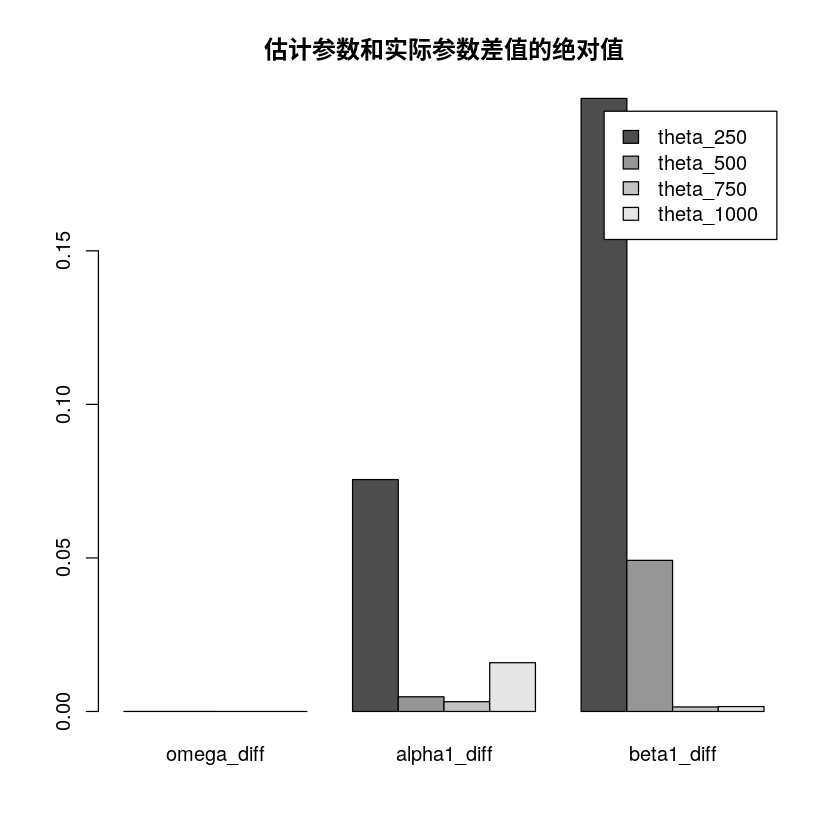

In [23]:
barplot(abs(result[2: 5, 4: 6]),
        main="估计参数和实际参数差值的绝对值",
        legend=rownames(result)[2: 5], beside=T)

# 作业
使用data.csv里面福特公司“Ford”的价格序列，进行GARCH(2, 2)估计得到实际参数，然后做数值模拟，并对比估计参数和实际参数的区别。